In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss
import os

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "0:2:3"


In [4]:
# initialize data attributes and loaders
save_name = f"assets/results/{dataset_name}/{model_name}/{ood}"
os.makedirs(os.path.dirname(save_name + "_blank.file"), exist_ok=True)
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 42153 images
Dataset type val label type: species


Loaded 5269 images
Dataset type test label type: species


 - Min class count:  976
Loaded 2928 images
Dataset type test label type: species


 - Min class count:  976
Loaded 17568 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:2:3 csroh3h4


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

  0%|                                                                                                                              | 0/330 [00:00<?, ?it/s]

  0%|▎                                                                                                                     | 1/330 [00:09<51:06,  9.32s/it]

  1%|▋                                                                                                                     | 2/330 [00:09<22:57,  4.20s/it]

  1%|█                                                                                                                     | 3/330 [00:10<13:55,  2.55s/it]

  1%|█▍                                                                                                                    | 4/330 [00:11<09:43,  1.79s/it]

  2%|█▊                                                                                                                    | 5/330 [00:11<07:21,  1.36s/it]

  2%|██▏                                                                                                                   | 6/330 [00:12<05:56,  1.10s/it]

  2%|██▌                                                                                                                   | 7/330 [00:12<05:03,  1.06it/s]

  2%|██▊                                                                                                                   | 8/330 [00:13<04:28,  1.20it/s]

  3%|███▏                                                                                                                  | 9/330 [00:14<04:03,  1.32it/s]

  3%|███▌                                                                                                                 | 10/330 [00:14<03:47,  1.41it/s]

  3%|███▉                                                                                                                 | 11/330 [00:15<03:37,  1.47it/s]

  4%|████▎                                                                                                                | 12/330 [00:15<03:28,  1.53it/s]

  4%|████▌                                                                                                                | 13/330 [00:16<03:22,  1.57it/s]

  4%|████▉                                                                                                                | 14/330 [00:17<03:18,  1.59it/s]

  5%|█████▎                                                                                                               | 15/330 [00:17<03:16,  1.61it/s]

  5%|█████▋                                                                                                               | 16/330 [00:18<03:13,  1.63it/s]

  5%|██████                                                                                                               | 17/330 [00:18<03:11,  1.64it/s]

  5%|██████▍                                                                                                              | 18/330 [00:19<03:10,  1.63it/s]

  6%|██████▋                                                                                                              | 19/330 [00:20<03:08,  1.65it/s]

  6%|███████                                                                                                              | 20/330 [00:20<03:07,  1.65it/s]

  6%|███████▍                                                                                                             | 21/330 [00:21<03:07,  1.65it/s]

  7%|███████▊                                                                                                             | 22/330 [00:22<03:06,  1.65it/s]

  7%|████████▏                                                                                                            | 23/330 [00:22<03:05,  1.66it/s]

  7%|████████▌                                                                                                            | 24/330 [00:23<03:04,  1.66it/s]

  8%|████████▊                                                                                                            | 25/330 [00:23<03:04,  1.65it/s]

  8%|█████████▏                                                                                                           | 26/330 [00:24<03:03,  1.66it/s]

  8%|█████████▌                                                                                                           | 27/330 [00:25<03:02,  1.66it/s]

  8%|█████████▉                                                                                                           | 28/330 [00:25<03:02,  1.66it/s]

  9%|██████████▎                                                                                                          | 29/330 [00:26<03:02,  1.65it/s]

  9%|██████████▋                                                                                                          | 30/330 [00:26<03:00,  1.66it/s]

  9%|██████████▉                                                                                                          | 31/330 [00:27<02:59,  1.66it/s]

 10%|███████████▎                                                                                                         | 32/330 [00:28<03:00,  1.65it/s]

 10%|███████████▋                                                                                                         | 33/330 [00:28<02:59,  1.66it/s]

 10%|████████████                                                                                                         | 34/330 [00:29<02:58,  1.66it/s]

 11%|████████████▍                                                                                                        | 35/330 [00:29<02:57,  1.66it/s]

 11%|████████████▊                                                                                                        | 36/330 [00:30<02:57,  1.65it/s]

 11%|█████████████                                                                                                        | 37/330 [00:31<02:56,  1.66it/s]

 12%|█████████████▍                                                                                                       | 38/330 [00:31<02:55,  1.66it/s]

 12%|█████████████▊                                                                                                       | 39/330 [00:32<02:56,  1.65it/s]

 12%|██████████████▏                                                                                                      | 40/330 [00:32<02:54,  1.66it/s]

 12%|██████████████▌                                                                                                      | 41/330 [00:33<02:53,  1.66it/s]

 13%|██████████████▉                                                                                                      | 42/330 [00:34<02:53,  1.66it/s]

 13%|███████████████▏                                                                                                     | 43/330 [00:34<02:53,  1.65it/s]

 13%|███████████████▌                                                                                                     | 44/330 [00:35<02:52,  1.66it/s]

 14%|███████████████▉                                                                                                     | 45/330 [00:35<02:51,  1.66it/s]

 14%|████████████████▎                                                                                                    | 46/330 [00:36<02:52,  1.65it/s]

 14%|████████████████▋                                                                                                    | 47/330 [00:37<02:50,  1.66it/s]

 15%|█████████████████                                                                                                    | 48/330 [00:37<02:49,  1.66it/s]

 15%|█████████████████▎                                                                                                   | 49/330 [00:38<02:49,  1.66it/s]

 15%|█████████████████▋                                                                                                   | 50/330 [00:38<02:49,  1.65it/s]

 15%|██████████████████                                                                                                   | 51/330 [00:39<02:48,  1.66it/s]

 16%|██████████████████▍                                                                                                  | 52/330 [00:40<02:47,  1.66it/s]

 16%|██████████████████▊                                                                                                  | 53/330 [00:40<02:47,  1.65it/s]

 16%|███████████████████▏                                                                                                 | 54/330 [00:41<02:46,  1.66it/s]

 17%|███████████████████▌                                                                                                 | 55/330 [00:41<02:45,  1.66it/s]

 17%|███████████████████▊                                                                                                 | 56/330 [00:42<02:45,  1.66it/s]

 17%|████████████████████▏                                                                                                | 57/330 [00:43<02:45,  1.65it/s]

 18%|████████████████████▌                                                                                                | 58/330 [00:43<02:43,  1.66it/s]

 18%|████████████████████▉                                                                                                | 59/330 [00:44<02:42,  1.66it/s]

 18%|█████████████████████▎                                                                                               | 60/330 [00:44<02:43,  1.65it/s]

 18%|█████████████████████▋                                                                                               | 61/330 [00:45<02:42,  1.66it/s]

 19%|█████████████████████▉                                                                                               | 62/330 [00:46<02:41,  1.66it/s]

 19%|██████████████████████▎                                                                                              | 63/330 [00:46<02:41,  1.66it/s]

 19%|██████████████████████▋                                                                                              | 64/330 [00:47<02:40,  1.65it/s]

 20%|███████████████████████                                                                                              | 65/330 [00:47<02:39,  1.66it/s]

 20%|███████████████████████▍                                                                                             | 66/330 [00:48<02:38,  1.66it/s]

 20%|███████████████████████▊                                                                                             | 67/330 [00:49<02:39,  1.65it/s]

 21%|████████████████████████                                                                                             | 68/330 [00:49<02:38,  1.66it/s]

 21%|████████████████████████▍                                                                                            | 69/330 [00:50<02:37,  1.66it/s]

 21%|████████████████████████▊                                                                                            | 70/330 [00:50<02:36,  1.66it/s]

 22%|█████████████████████████▏                                                                                           | 71/330 [00:51<02:36,  1.65it/s]

 22%|█████████████████████████▌                                                                                           | 72/330 [00:52<02:35,  1.66it/s]

 22%|█████████████████████████▉                                                                                           | 73/330 [00:52<02:34,  1.66it/s]

 22%|██████████████████████████▏                                                                                          | 74/330 [00:53<02:35,  1.65it/s]

 23%|██████████████████████████▌                                                                                          | 75/330 [00:53<02:33,  1.66it/s]

 23%|██████████████████████████▉                                                                                          | 76/330 [00:54<02:32,  1.66it/s]

 23%|███████████████████████████▎                                                                                         | 77/330 [00:55<02:32,  1.66it/s]

 24%|███████████████████████████▋                                                                                         | 78/330 [00:55<02:32,  1.65it/s]

 24%|████████████████████████████                                                                                         | 79/330 [00:56<02:31,  1.66it/s]

 24%|████████████████████████████▎                                                                                        | 80/330 [00:56<02:30,  1.66it/s]

 25%|████████████████████████████▋                                                                                        | 81/330 [00:57<02:30,  1.65it/s]

 25%|█████████████████████████████                                                                                        | 82/330 [00:58<02:29,  1.66it/s]

 25%|█████████████████████████████▍                                                                                       | 83/330 [00:58<02:28,  1.66it/s]

 25%|█████████████████████████████▊                                                                                       | 84/330 [00:59<02:28,  1.66it/s]

 26%|██████████████████████████████▏                                                                                      | 85/330 [01:00<02:28,  1.65it/s]

 26%|██████████████████████████████▍                                                                                      | 86/330 [01:00<02:27,  1.66it/s]

 26%|██████████████████████████████▊                                                                                      | 87/330 [01:01<02:26,  1.66it/s]

 27%|███████████████████████████████▏                                                                                     | 88/330 [01:01<02:26,  1.65it/s]

 27%|███████████████████████████████▌                                                                                     | 89/330 [01:02<02:25,  1.66it/s]

 27%|███████████████████████████████▉                                                                                     | 90/330 [01:03<02:24,  1.66it/s]

 28%|████████████████████████████████▎                                                                                    | 91/330 [01:03<02:24,  1.66it/s]

 28%|████████████████████████████████▌                                                                                    | 92/330 [01:04<02:24,  1.65it/s]

 28%|████████████████████████████████▉                                                                                    | 93/330 [01:04<02:23,  1.66it/s]

 28%|█████████████████████████████████▎                                                                                   | 94/330 [01:05<02:22,  1.66it/s]

 29%|█████████████████████████████████▋                                                                                   | 95/330 [01:06<02:22,  1.65it/s]

 29%|██████████████████████████████████                                                                                   | 96/330 [01:06<02:21,  1.65it/s]

 29%|██████████████████████████████████▍                                                                                  | 97/330 [01:07<02:20,  1.66it/s]

 30%|██████████████████████████████████▋                                                                                  | 98/330 [01:07<02:20,  1.65it/s]

 30%|███████████████████████████████████                                                                                  | 99/330 [01:08<02:20,  1.65it/s]

 30%|███████████████████████████████████▏                                                                                | 100/330 [01:09<02:18,  1.66it/s]

 31%|███████████████████████████████████▌                                                                                | 101/330 [01:09<02:18,  1.66it/s]

 31%|███████████████████████████████████▊                                                                                | 102/330 [01:10<02:18,  1.65it/s]

 31%|████████████████████████████████████▏                                                                               | 103/330 [01:10<02:17,  1.65it/s]

 32%|████████████████████████████████████▌                                                                               | 104/330 [01:11<02:16,  1.66it/s]

 32%|████████████████████████████████████▉                                                                               | 105/330 [01:12<02:15,  1.65it/s]

 32%|█████████████████████████████████████▎                                                                              | 106/330 [01:12<02:15,  1.65it/s]

 32%|█████████████████████████████████████▌                                                                              | 107/330 [01:13<02:14,  1.66it/s]

 33%|█████████████████████████████████████▉                                                                              | 108/330 [01:13<02:13,  1.66it/s]

 33%|██████████████████████████████████████▎                                                                             | 109/330 [01:14<02:14,  1.65it/s]

 33%|██████████████████████████████████████▋                                                                             | 110/330 [01:15<02:12,  1.65it/s]

 34%|███████████████████████████████████████                                                                             | 111/330 [01:15<02:12,  1.66it/s]

 34%|███████████████████████████████████████▎                                                                            | 112/330 [01:16<02:11,  1.66it/s]

 34%|███████████████████████████████████████▋                                                                            | 113/330 [01:16<02:11,  1.65it/s]

 35%|████████████████████████████████████████                                                                            | 114/330 [01:17<02:10,  1.66it/s]

 35%|████████████████████████████████████████▍                                                                           | 115/330 [01:18<02:09,  1.66it/s]

 35%|████████████████████████████████████████▊                                                                           | 116/330 [01:18<02:09,  1.65it/s]

 35%|█████████████████████████████████████████▏                                                                          | 117/330 [01:19<02:08,  1.65it/s]

 36%|█████████████████████████████████████████▍                                                                          | 118/330 [01:19<02:07,  1.66it/s]

 36%|█████████████████████████████████████████▊                                                                          | 119/330 [01:20<02:07,  1.65it/s]

 36%|██████████████████████████████████████████▏                                                                         | 120/330 [01:21<02:07,  1.65it/s]

 37%|██████████████████████████████████████████▌                                                                         | 121/330 [01:21<02:06,  1.66it/s]

 37%|██████████████████████████████████████████▉                                                                         | 122/330 [01:22<02:05,  1.66it/s]

 37%|███████████████████████████████████████████▏                                                                        | 123/330 [01:22<02:05,  1.65it/s]

 38%|███████████████████████████████████████████▌                                                                        | 124/330 [01:23<02:04,  1.65it/s]

 38%|███████████████████████████████████████████▉                                                                        | 125/330 [01:24<02:03,  1.66it/s]

 38%|████████████████████████████████████████████▎                                                                       | 126/330 [01:24<02:03,  1.66it/s]

 38%|████████████████████████████████████████████▋                                                                       | 127/330 [01:25<02:03,  1.65it/s]

 39%|████████████████████████████████████████████▉                                                                       | 128/330 [01:25<02:01,  1.66it/s]

 39%|█████████████████████████████████████████████▎                                                                      | 129/330 [01:26<02:01,  1.66it/s]

 39%|█████████████████████████████████████████████▋                                                                      | 130/330 [01:27<02:01,  1.65it/s]

 40%|██████████████████████████████████████████████                                                                      | 131/330 [01:27<02:00,  1.65it/s]

 40%|██████████████████████████████████████████████▍                                                                     | 132/330 [01:28<01:59,  1.66it/s]

 40%|██████████████████████████████████████████████▊                                                                     | 133/330 [01:29<01:59,  1.65it/s]

 41%|███████████████████████████████████████████████                                                                     | 134/330 [01:29<01:58,  1.65it/s]

 41%|███████████████████████████████████████████████▍                                                                    | 135/330 [01:30<01:57,  1.66it/s]

 41%|███████████████████████████████████████████████▊                                                                    | 136/330 [01:30<01:56,  1.66it/s]

 42%|████████████████████████████████████████████████▏                                                                   | 137/330 [01:31<01:57,  1.65it/s]

 42%|████████████████████████████████████████████████▌                                                                   | 138/330 [01:32<01:56,  1.65it/s]

 42%|████████████████████████████████████████████████▊                                                                   | 139/330 [01:32<01:55,  1.66it/s]

 42%|█████████████████████████████████████████████████▏                                                                  | 140/330 [01:33<01:54,  1.65it/s]

 43%|█████████████████████████████████████████████████▌                                                                  | 141/330 [01:33<01:54,  1.65it/s]

 43%|█████████████████████████████████████████████████▉                                                                  | 142/330 [01:34<01:53,  1.66it/s]

 43%|██████████████████████████████████████████████████▎                                                                 | 143/330 [01:35<01:52,  1.66it/s]

 44%|██████████████████████████████████████████████████▌                                                                 | 144/330 [01:35<01:52,  1.65it/s]

 44%|██████████████████████████████████████████████████▉                                                                 | 145/330 [01:36<01:51,  1.65it/s]

 44%|███████████████████████████████████████████████████▎                                                                | 146/330 [01:36<01:50,  1.66it/s]

 45%|███████████████████████████████████████████████████▋                                                                | 147/330 [01:37<01:50,  1.65it/s]

 45%|████████████████████████████████████████████████████                                                                | 148/330 [01:38<01:50,  1.65it/s]

 45%|████████████████████████████████████████████████████▍                                                               | 149/330 [01:38<01:49,  1.66it/s]

 45%|████████████████████████████████████████████████████▋                                                               | 150/330 [01:39<01:48,  1.66it/s]

 46%|█████████████████████████████████████████████████████                                                               | 151/330 [01:39<01:48,  1.65it/s]

 46%|█████████████████████████████████████████████████████▍                                                              | 152/330 [01:40<01:47,  1.65it/s]

 46%|█████████████████████████████████████████████████████▊                                                              | 153/330 [01:41<01:46,  1.66it/s]

 47%|██████████████████████████████████████████████████████▏                                                             | 154/330 [01:41<01:46,  1.65it/s]

 47%|██████████████████████████████████████████████████████▍                                                             | 155/330 [01:42<01:46,  1.65it/s]

 47%|██████████████████████████████████████████████████████▊                                                             | 156/330 [01:42<01:45,  1.66it/s]

 48%|███████████████████████████████████████████████████████▏                                                            | 157/330 [01:43<01:44,  1.66it/s]

 48%|███████████████████████████████████████████████████████▌                                                            | 158/330 [01:44<01:44,  1.65it/s]

 48%|███████████████████████████████████████████████████████▉                                                            | 159/330 [01:44<01:43,  1.65it/s]

 48%|████████████████████████████████████████████████████████▏                                                           | 160/330 [01:45<01:42,  1.66it/s]

 49%|████████████████████████████████████████████████████████▌                                                           | 161/330 [01:45<01:42,  1.65it/s]

 49%|████████████████████████████████████████████████████████▉                                                           | 162/330 [01:46<01:41,  1.65it/s]

 49%|█████████████████████████████████████████████████████████▎                                                          | 163/330 [01:47<01:40,  1.66it/s]

 50%|█████████████████████████████████████████████████████████▋                                                          | 164/330 [01:47<01:40,  1.66it/s]

 50%|██████████████████████████████████████████████████████████                                                          | 165/330 [01:48<01:40,  1.65it/s]

 50%|██████████████████████████████████████████████████████████▎                                                         | 166/330 [01:48<01:39,  1.66it/s]

 51%|██████████████████████████████████████████████████████████▋                                                         | 167/330 [01:49<01:38,  1.66it/s]

 51%|███████████████████████████████████████████████████████████                                                         | 168/330 [01:50<01:37,  1.65it/s]

 51%|███████████████████████████████████████████████████████████▍                                                        | 169/330 [01:50<01:37,  1.65it/s]

 52%|███████████████████████████████████████████████████████████▊                                                        | 170/330 [01:51<01:36,  1.66it/s]

 52%|████████████████████████████████████████████████████████████                                                        | 171/330 [01:51<01:35,  1.66it/s]

 52%|████████████████████████████████████████████████████████████▍                                                       | 172/330 [01:52<01:35,  1.65it/s]

 52%|████████████████████████████████████████████████████████████▊                                                       | 173/330 [01:53<01:34,  1.65it/s]

 53%|█████████████████████████████████████████████████████████████▏                                                      | 174/330 [01:53<01:33,  1.66it/s]

 53%|█████████████████████████████████████████████████████████████▌                                                      | 175/330 [01:54<01:33,  1.65it/s]

 53%|█████████████████████████████████████████████████████████████▊                                                      | 176/330 [01:55<01:33,  1.65it/s]

 54%|██████████████████████████████████████████████████████████████▏                                                     | 177/330 [01:55<01:32,  1.66it/s]

 54%|██████████████████████████████████████████████████████████████▌                                                     | 178/330 [01:56<01:31,  1.66it/s]

 54%|██████████████████████████████████████████████████████████████▉                                                     | 179/330 [01:56<01:31,  1.65it/s]

 55%|███████████████████████████████████████████████████████████████▎                                                    | 180/330 [01:57<01:30,  1.65it/s]

 55%|███████████████████████████████████████████████████████████████▌                                                    | 181/330 [01:58<01:29,  1.66it/s]

 55%|███████████████████████████████████████████████████████████████▉                                                    | 182/330 [01:58<01:29,  1.65it/s]

 55%|████████████████████████████████████████████████████████████████▎                                                   | 183/330 [01:59<01:29,  1.65it/s]

 56%|████████████████████████████████████████████████████████████████▋                                                   | 184/330 [01:59<01:28,  1.66it/s]

 56%|█████████████████████████████████████████████████████████████████                                                   | 185/330 [02:00<01:27,  1.66it/s]

 56%|█████████████████████████████████████████████████████████████████▍                                                  | 186/330 [02:01<01:27,  1.65it/s]

 57%|█████████████████████████████████████████████████████████████████▋                                                  | 187/330 [02:01<01:26,  1.65it/s]

 57%|██████████████████████████████████████████████████████████████████                                                  | 188/330 [02:02<01:25,  1.66it/s]

 57%|██████████████████████████████████████████████████████████████████▍                                                 | 189/330 [02:02<01:25,  1.65it/s]

 58%|██████████████████████████████████████████████████████████████████▊                                                 | 190/330 [02:03<01:24,  1.65it/s]

 58%|███████████████████████████████████████████████████████████████████▏                                                | 191/330 [02:04<01:23,  1.66it/s]

 58%|███████████████████████████████████████████████████████████████████▍                                                | 192/330 [02:04<01:23,  1.66it/s]

 58%|███████████████████████████████████████████████████████████████████▊                                                | 193/330 [02:05<01:23,  1.65it/s]

 59%|████████████████████████████████████████████████████████████████████▏                                               | 194/330 [02:05<01:22,  1.65it/s]

 59%|████████████████████████████████████████████████████████████████████▌                                               | 195/330 [02:06<01:21,  1.66it/s]

 59%|████████████████████████████████████████████████████████████████████▉                                               | 196/330 [02:07<01:21,  1.65it/s]

 60%|█████████████████████████████████████████████████████████████████████▏                                              | 197/330 [02:07<01:20,  1.65it/s]

 60%|█████████████████████████████████████████████████████████████████████▌                                              | 198/330 [02:08<01:19,  1.66it/s]

 60%|█████████████████████████████████████████████████████████████████████▉                                              | 199/330 [02:08<01:18,  1.66it/s]

 61%|██████████████████████████████████████████████████████████████████████▎                                             | 200/330 [02:09<01:18,  1.65it/s]

 61%|██████████████████████████████████████████████████████████████████████▋                                             | 201/330 [02:10<01:18,  1.65it/s]

 61%|███████████████████████████████████████████████████████████████████████                                             | 202/330 [02:10<01:17,  1.66it/s]

 62%|███████████████████████████████████████████████████████████████████████▎                                            | 203/330 [02:11<01:16,  1.65it/s]

 62%|███████████████████████████████████████████████████████████████████████▋                                            | 204/330 [02:11<01:16,  1.65it/s]

 62%|████████████████████████████████████████████████████████████████████████                                            | 205/330 [02:12<01:15,  1.66it/s]

 62%|████████████████████████████████████████████████████████████████████████▍                                           | 206/330 [02:13<01:14,  1.66it/s]

 63%|████████████████████████████████████████████████████████████████████████▊                                           | 207/330 [02:13<01:14,  1.65it/s]

 63%|█████████████████████████████████████████████████████████████████████████                                           | 208/330 [02:14<01:13,  1.65it/s]

 63%|█████████████████████████████████████████████████████████████████████████▍                                          | 209/330 [02:14<01:12,  1.66it/s]

 64%|█████████████████████████████████████████████████████████████████████████▊                                          | 210/330 [02:15<01:12,  1.65it/s]

 64%|██████████████████████████████████████████████████████████████████████████▏                                         | 211/330 [02:16<01:12,  1.65it/s]

 64%|██████████████████████████████████████████████████████████████████████████▌                                         | 212/330 [02:16<01:11,  1.65it/s]

 65%|██████████████████████████████████████████████████████████████████████████▊                                         | 213/330 [02:17<01:10,  1.66it/s]

 65%|███████████████████████████████████████████████████████████████████████████▏                                        | 214/330 [02:17<01:10,  1.65it/s]

 65%|███████████████████████████████████████████████████████████████████████████▌                                        | 215/330 [02:18<01:09,  1.65it/s]

 65%|███████████████████████████████████████████████████████████████████████████▉                                        | 216/330 [02:19<01:08,  1.66it/s]

 66%|████████████████████████████████████████████████████████████████████████████▎                                       | 217/330 [02:19<01:08,  1.65it/s]

 66%|████████████████████████████████████████████████████████████████████████████▋                                       | 218/330 [02:20<01:07,  1.65it/s]

 66%|████████████████████████████████████████████████████████████████████████████▉                                       | 219/330 [02:21<01:07,  1.65it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▎                                      | 220/330 [02:21<01:06,  1.66it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▋                                      | 221/330 [02:22<01:06,  1.65it/s]

 67%|██████████████████████████████████████████████████████████████████████████████                                      | 222/330 [02:22<01:05,  1.65it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▍                                     | 223/330 [02:23<01:04,  1.66it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▋                                     | 224/330 [02:24<01:04,  1.65it/s]

 68%|███████████████████████████████████████████████████████████████████████████████                                     | 225/330 [02:24<01:03,  1.65it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▍                                    | 226/330 [02:25<01:02,  1.65it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▊                                    | 227/330 [02:25<01:02,  1.66it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▏                                   | 228/330 [02:26<01:01,  1.65it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▍                                   | 229/330 [02:27<01:01,  1.65it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▊                                   | 230/330 [02:27<01:00,  1.66it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▏                                  | 231/330 [02:28<00:59,  1.65it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▌                                  | 232/330 [02:28<00:59,  1.65it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▉                                  | 233/330 [02:29<00:58,  1.65it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▎                                 | 234/330 [02:30<00:57,  1.66it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▌                                 | 235/330 [02:30<00:57,  1.65it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▉                                 | 236/330 [02:31<00:56,  1.65it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▎                                | 237/330 [02:31<00:56,  1.66it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▋                                | 238/330 [02:32<00:55,  1.65it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████                                | 239/330 [02:33<00:55,  1.65it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▎                               | 240/330 [02:33<00:54,  1.66it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▋                               | 241/330 [02:34<00:53,  1.66it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████                               | 242/330 [02:34<00:53,  1.65it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▍                              | 243/330 [02:35<00:52,  1.65it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▊                              | 244/330 [02:36<00:51,  1.66it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████                              | 245/330 [02:36<00:51,  1.65it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▍                             | 246/330 [02:37<00:50,  1.65it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▊                             | 247/330 [02:37<00:50,  1.66it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▏                            | 248/330 [02:38<00:49,  1.66it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▌                            | 249/330 [02:39<00:49,  1.65it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▉                            | 250/330 [02:39<00:48,  1.65it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▏                           | 251/330 [02:40<00:47,  1.66it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▌                           | 252/330 [02:40<00:47,  1.65it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▉                           | 253/330 [02:41<00:46,  1.65it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▎                          | 254/330 [02:42<00:45,  1.66it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▋                          | 255/330 [02:42<00:45,  1.66it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▉                          | 256/330 [02:43<00:44,  1.65it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▎                         | 257/330 [02:43<00:44,  1.65it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▋                         | 258/330 [02:44<00:43,  1.66it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████                         | 259/330 [02:45<00:42,  1.65it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▍                        | 260/330 [02:45<00:42,  1.65it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▋                        | 261/330 [02:46<00:41,  1.66it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████                        | 262/330 [02:47<00:40,  1.66it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▍                       | 263/330 [02:47<00:40,  1.65it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▊                       | 264/330 [02:48<00:39,  1.65it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▏                      | 265/330 [02:48<00:39,  1.66it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▌                      | 266/330 [02:49<00:38,  1.65it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▊                      | 267/330 [02:50<00:38,  1.65it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▏                     | 268/330 [02:50<00:37,  1.66it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▌                     | 269/330 [02:51<00:36,  1.66it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▉                     | 270/330 [02:51<00:36,  1.65it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▎                    | 271/330 [02:52<00:35,  1.65it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▌                    | 272/330 [02:53<00:34,  1.66it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▉                    | 273/330 [02:53<00:34,  1.66it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 274/330 [02:54<00:33,  1.65it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 275/330 [02:54<00:33,  1.66it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████                   | 276/330 [02:55<00:32,  1.66it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 277/330 [02:56<00:32,  1.65it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 278/330 [02:56<00:31,  1.65it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████                  | 279/330 [02:57<00:30,  1.66it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 280/330 [02:57<00:30,  1.65it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 281/330 [02:58<00:29,  1.65it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                | 282/330 [02:59<00:28,  1.66it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                | 283/330 [02:59<00:28,  1.66it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                | 284/330 [03:00<00:27,  1.65it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 285/330 [03:00<00:27,  1.65it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 286/330 [03:01<00:26,  1.66it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 287/330 [03:02<00:25,  1.66it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 288/330 [03:02<00:25,  1.65it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 289/330 [03:03<00:24,  1.66it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 290/330 [03:03<00:24,  1.66it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 291/330 [03:04<00:23,  1.65it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 292/330 [03:05<00:22,  1.65it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 293/330 [03:05<00:22,  1.66it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 294/330 [03:06<00:21,  1.66it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 295/330 [03:06<00:21,  1.65it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████            | 296/330 [03:07<00:20,  1.66it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 297/330 [03:08<00:19,  1.66it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 298/330 [03:08<00:19,  1.65it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████           | 299/330 [03:09<00:18,  1.65it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 300/330 [03:09<00:18,  1.66it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 301/330 [03:10<00:17,  1.66it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 302/330 [03:11<00:16,  1.65it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 303/330 [03:11<00:16,  1.66it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 304/330 [03:12<00:15,  1.66it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 305/330 [03:13<00:15,  1.65it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 306/330 [03:13<00:14,  1.65it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 307/330 [03:14<00:13,  1.66it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 308/330 [03:14<00:13,  1.65it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 309/330 [03:15<00:12,  1.65it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 310/330 [03:16<00:12,  1.66it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 311/330 [03:16<00:11,  1.66it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 312/330 [03:17<00:10,  1.65it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 313/330 [03:17<00:10,  1.65it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 314/330 [03:18<00:09,  1.66it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 315/330 [03:19<00:09,  1.65it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 316/330 [03:19<00:08,  1.65it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 317/330 [03:20<00:07,  1.66it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 318/330 [03:20<00:07,  1.66it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 319/330 [03:21<00:06,  1.65it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 320/330 [03:22<00:06,  1.65it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 321/330 [03:22<00:05,  1.66it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 322/330 [03:23<00:04,  1.65it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 323/330 [03:23<00:04,  1.65it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 324/330 [03:24<00:03,  1.66it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 325/330 [03:25<00:03,  1.66it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 326/330 [03:25<00:02,  1.65it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 327/330 [03:26<00:01,  1.65it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 328/330 [03:26<00:01,  1.66it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 329/330 [03:27<00:00,  1.65it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 330/330 [03:27<00:00,  1.81it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 330/330 [03:27<00:00,  1.59it/s]

train - OK


  0%|                                                                                                                               | 0/42 [00:00<?, ?it/s]

  2%|██▊                                                                                                                    | 1/42 [00:00<00:28,  1.42it/s]

  5%|█████▋                                                                                                                 | 2/42 [00:01<00:25,  1.56it/s]

  7%|████████▌                                                                                                              | 3/42 [00:01<00:24,  1.61it/s]

 10%|███████████▎                                                                                                           | 4/42 [00:02<00:23,  1.61it/s]

 12%|██████████████▏                                                                                                        | 5/42 [00:03<00:22,  1.63it/s]

 14%|█████████████████                                                                                                      | 6/42 [00:03<00:21,  1.65it/s]

 17%|███████████████████▊                                                                                                   | 7/42 [00:04<00:21,  1.65it/s]

 19%|██████████████████████▋                                                                                                | 8/42 [00:04<00:20,  1.65it/s]

 21%|█████████████████████████▌                                                                                             | 9/42 [00:05<00:19,  1.65it/s]

 24%|████████████████████████████                                                                                          | 10/42 [00:06<00:19,  1.66it/s]

 26%|██████████████████████████████▉                                                                                       | 11/42 [00:06<00:18,  1.65it/s]

 29%|█████████████████████████████████▋                                                                                    | 12/42 [00:07<00:18,  1.66it/s]

 31%|████████████████████████████████████▌                                                                                 | 13/42 [00:07<00:17,  1.66it/s]

 33%|███████████████████████████████████████▎                                                                              | 14/42 [00:08<00:16,  1.65it/s]

 36%|██████████████████████████████████████████▏                                                                           | 15/42 [00:09<00:16,  1.65it/s]

 38%|████████████████████████████████████████████▉                                                                         | 16/42 [00:09<00:15,  1.66it/s]

 40%|███████████████████████████████████████████████▊                                                                      | 17/42 [00:10<00:15,  1.66it/s]

 43%|██████████████████████████████████████████████████▌                                                                   | 18/42 [00:10<00:14,  1.65it/s]

 45%|█████████████████████████████████████████████████████▍                                                                | 19/42 [00:11<00:13,  1.65it/s]

 48%|████████████████████████████████████████████████████████▏                                                             | 20/42 [00:12<00:13,  1.66it/s]

 50%|███████████████████████████████████████████████████████████                                                           | 21/42 [00:12<00:12,  1.65it/s]

 52%|█████████████████████████████████████████████████████████████▊                                                        | 22/42 [00:13<00:12,  1.65it/s]

 55%|████████████████████████████████████████████████████████████████▌                                                     | 23/42 [00:13<00:11,  1.65it/s]

 57%|███████████████████████████████████████████████████████████████████▍                                                  | 24/42 [00:14<00:10,  1.66it/s]

 60%|██████████████████████████████████████████████████████████████████████▏                                               | 25/42 [00:15<00:10,  1.65it/s]

 62%|█████████████████████████████████████████████████████████████████████████                                             | 26/42 [00:15<00:09,  1.65it/s]

 64%|███████████████████████████████████████████████████████████████████████████▊                                          | 27/42 [00:16<00:09,  1.66it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▋                                       | 28/42 [00:17<00:08,  1.65it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████▍                                    | 29/42 [00:17<00:07,  1.65it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████▎                                 | 30/42 [00:18<00:07,  1.65it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████                               | 31/42 [00:18<00:06,  1.66it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████▉                            | 32/42 [00:19<00:06,  1.65it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████▋                         | 33/42 [00:20<00:05,  1.65it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████▌                      | 34/42 [00:20<00:04,  1.66it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 35/42 [00:21<00:04,  1.65it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 36/42 [00:21<00:03,  1.65it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 37/42 [00:22<00:03,  1.65it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 38/42 [00:23<00:02,  1.66it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 39/42 [00:23<00:01,  1.65it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 40/42 [00:24<00:01,  1.65it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 41/42 [00:24<00:00,  1.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:25<00:00,  1.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]

val - OK


  0%|                                                                                                                               | 0/23 [00:00<?, ?it/s]

  4%|█████▏                                                                                                                 | 1/23 [00:00<00:16,  1.37it/s]

  9%|██████████▎                                                                                                            | 2/23 [00:01<00:14,  1.49it/s]

 13%|███████████████▌                                                                                                       | 3/23 [00:01<00:12,  1.57it/s]

 17%|████████████████████▋                                                                                                  | 4/23 [00:02<00:11,  1.61it/s]

 22%|█████████████████████████▊                                                                                             | 5/23 [00:03<00:11,  1.62it/s]

 26%|███████████████████████████████                                                                                        | 6/23 [00:03<00:10,  1.63it/s]

 30%|████████████████████████████████████▏                                                                                  | 7/23 [00:04<00:09,  1.64it/s]

 35%|█████████████████████████████████████████▍                                                                             | 8/23 [00:04<00:09,  1.65it/s]

 39%|██████████████████████████████████████████████▌                                                                        | 9/23 [00:05<00:08,  1.64it/s]

 43%|███████████████████████████████████████████████████▎                                                                  | 10/23 [00:06<00:07,  1.65it/s]

 48%|████████████████████████████████████████████████████████▍                                                             | 11/23 [00:06<00:07,  1.65it/s]

 52%|█████████████████████████████████████████████████████████████▌                                                        | 12/23 [00:07<00:06,  1.65it/s]

 57%|██████████████████████████████████████████████████████████████████▋                                                   | 13/23 [00:08<00:06,  1.65it/s]

 61%|███████████████████████████████████████████████████████████████████████▊                                              | 14/23 [00:08<00:05,  1.65it/s]

 65%|████████████████████████████████████████████████████████████████████████████▉                                         | 15/23 [00:09<00:04,  1.66it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████                                    | 16/23 [00:09<00:04,  1.65it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████▏                              | 17/23 [00:10<00:03,  1.65it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████▎                         | 18/23 [00:11<00:03,  1.66it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 19/23 [00:11<00:02,  1.65it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 20/23 [00:12<00:01,  1.65it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 21/23 [00:12<00:01,  1.65it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 22/23 [00:13<00:00,  1.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:14<00:00,  1.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:14<00:00,  1.63it/s]

test InD - OK


  0%|                                                                                                                              | 0/138 [00:00<?, ?it/s]

  1%|▊                                                                                                                     | 1/138 [00:00<00:55,  2.45it/s]

  1%|█▋                                                                                                                    | 2/138 [00:00<00:36,  3.71it/s]

  2%|██▌                                                                                                                   | 3/138 [00:01<00:47,  2.85it/s]

  3%|███▍                                                                                                                  | 4/138 [00:01<01:00,  2.21it/s]

  4%|████▎                                                                                                                 | 5/138 [00:02<01:07,  1.98it/s]

  4%|█████▏                                                                                                                | 6/138 [00:02<01:10,  1.86it/s]

  5%|█████▉                                                                                                                | 7/138 [00:03<01:13,  1.78it/s]

  6%|██████▊                                                                                                               | 8/138 [00:04<01:14,  1.74it/s]

  7%|███████▋                                                                                                              | 9/138 [00:04<01:14,  1.72it/s]

  7%|████████▍                                                                                                            | 10/138 [00:05<01:15,  1.70it/s]

  8%|█████████▎                                                                                                           | 11/138 [00:05<01:15,  1.68it/s]

  9%|██████████▏                                                                                                          | 12/138 [00:06<01:15,  1.68it/s]

  9%|███████████                                                                                                          | 13/138 [00:07<01:14,  1.68it/s]

 10%|███████████▊                                                                                                         | 14/138 [00:07<01:14,  1.66it/s]

 11%|████████████▋                                                                                                        | 15/138 [00:08<01:13,  1.66it/s]

 12%|█████████████▌                                                                                                       | 16/138 [00:08<01:13,  1.67it/s]

 12%|██████████████▍                                                                                                      | 17/138 [00:09<01:12,  1.66it/s]

 13%|███████████████▎                                                                                                     | 18/138 [00:10<01:12,  1.65it/s]

 14%|████████████████                                                                                                     | 19/138 [00:10<01:11,  1.66it/s]

 14%|████████████████▉                                                                                                    | 20/138 [00:11<01:10,  1.66it/s]

 15%|█████████████████▊                                                                                                   | 21/138 [00:11<01:10,  1.65it/s]

 16%|██████████████████▋                                                                                                  | 22/138 [00:12<01:09,  1.66it/s]

 17%|███████████████████▌                                                                                                 | 23/138 [00:13<01:09,  1.66it/s]

 17%|████████████████████▎                                                                                                | 24/138 [00:13<01:08,  1.66it/s]

 18%|█████████████████████▏                                                                                               | 25/138 [00:14<01:08,  1.65it/s]

 19%|██████████████████████                                                                                               | 26/138 [00:14<01:07,  1.66it/s]

 20%|██████████████████████▉                                                                                              | 27/138 [00:15<01:06,  1.66it/s]

 20%|███████████████████████▋                                                                                             | 28/138 [00:16<01:06,  1.65it/s]

 21%|████████████████████████▌                                                                                            | 29/138 [00:16<01:05,  1.66it/s]

 22%|█████████████████████████▍                                                                                           | 30/138 [00:17<01:05,  1.66it/s]

 22%|██████████████████████████▎                                                                                          | 31/138 [00:17<01:04,  1.66it/s]

 23%|███████████████████████████▏                                                                                         | 32/138 [00:18<01:04,  1.65it/s]

 24%|███████████████████████████▉                                                                                         | 33/138 [00:19<01:03,  1.66it/s]

 25%|████████████████████████████▊                                                                                        | 34/138 [00:19<01:02,  1.66it/s]

 25%|█████████████████████████████▋                                                                                       | 35/138 [00:20<01:02,  1.65it/s]

 26%|██████████████████████████████▌                                                                                      | 36/138 [00:20<01:01,  1.66it/s]

 27%|███████████████████████████████▎                                                                                     | 37/138 [00:21<01:00,  1.66it/s]

 28%|████████████████████████████████▏                                                                                    | 38/138 [00:22<01:00,  1.66it/s]

 28%|█████████████████████████████████                                                                                    | 39/138 [00:22<00:59,  1.65it/s]

 29%|█████████████████████████████████▉                                                                                   | 40/138 [00:23<00:59,  1.66it/s]

 30%|██████████████████████████████████▊                                                                                  | 41/138 [00:23<00:58,  1.66it/s]

 30%|███████████████████████████████████▌                                                                                 | 42/138 [00:24<00:58,  1.65it/s]

 31%|████████████████████████████████████▍                                                                                | 43/138 [00:25<00:57,  1.66it/s]

 32%|█████████████████████████████████████▎                                                                               | 44/138 [00:25<00:56,  1.66it/s]

 33%|██████████████████████████████████████▏                                                                              | 45/138 [00:26<00:56,  1.66it/s]

 33%|███████████████████████████████████████                                                                              | 46/138 [00:26<00:55,  1.65it/s]

 34%|███████████████████████████████████████▊                                                                             | 47/138 [00:27<00:54,  1.66it/s]

 35%|████████████████████████████████████████▋                                                                            | 48/138 [00:28<00:54,  1.66it/s]

 36%|█████████████████████████████████████████▌                                                                           | 49/138 [00:28<00:53,  1.65it/s]

 36%|██████████████████████████████████████████▍                                                                          | 50/138 [00:29<00:53,  1.66it/s]

 37%|███████████████████████████████████████████▏                                                                         | 51/138 [00:29<00:52,  1.66it/s]

 38%|████████████████████████████████████████████                                                                         | 52/138 [00:30<00:51,  1.66it/s]

 38%|████████████████████████████████████████████▉                                                                        | 53/138 [00:31<00:51,  1.65it/s]

 39%|█████████████████████████████████████████████▊                                                                       | 54/138 [00:31<00:50,  1.66it/s]

 40%|██████████████████████████████████████████████▋                                                                      | 55/138 [00:32<00:49,  1.66it/s]

 41%|███████████████████████████████████████████████▍                                                                     | 56/138 [00:33<00:49,  1.65it/s]

 41%|████████████████████████████████████████████████▎                                                                    | 57/138 [00:33<00:48,  1.66it/s]

 42%|█████████████████████████████████████████████████▏                                                                   | 58/138 [00:34<00:48,  1.66it/s]

 43%|██████████████████████████████████████████████████                                                                   | 59/138 [00:34<00:46,  1.68it/s]

 43%|██████████████████████████████████████████████████▊                                                                  | 60/138 [00:35<00:46,  1.68it/s]

 44%|███████████████████████████████████████████████████▋                                                                 | 61/138 [00:35<00:45,  1.68it/s]

 45%|████████████████████████████████████████████████████▌                                                                | 62/138 [00:36<00:45,  1.67it/s]

 46%|█████████████████████████████████████████████████████▍                                                               | 63/138 [00:37<00:45,  1.66it/s]

 46%|██████████████████████████████████████████████████████▎                                                              | 64/138 [00:37<00:44,  1.66it/s]

 47%|███████████████████████████████████████████████████████                                                              | 65/138 [00:38<00:43,  1.67it/s]

 48%|███████████████████████████████████████████████████████▉                                                             | 66/138 [00:39<00:43,  1.65it/s]

 49%|████████████████████████████████████████████████████████▊                                                            | 67/138 [00:39<00:42,  1.66it/s]

 49%|█████████████████████████████████████████████████████████▋                                                           | 68/138 [00:40<00:42,  1.66it/s]

 50%|██████████████████████████████████████████████████████████▌                                                          | 69/138 [00:40<00:41,  1.66it/s]

 51%|███████████████████████████████████████████████████████████▎                                                         | 70/138 [00:41<00:41,  1.65it/s]

 51%|████████████████████████████████████████████████████████████▏                                                        | 71/138 [00:42<00:40,  1.66it/s]

 52%|█████████████████████████████████████████████████████████████                                                        | 72/138 [00:42<00:39,  1.66it/s]

 53%|█████████████████████████████████████████████████████████████▉                                                       | 73/138 [00:43<00:39,  1.65it/s]

 54%|██████████████████████████████████████████████████████████████▋                                                      | 74/138 [00:43<00:38,  1.66it/s]

 54%|███████████████████████████████████████████████████████████████▌                                                     | 75/138 [00:44<00:37,  1.66it/s]

 55%|████████████████████████████████████████████████████████████████▍                                                    | 76/138 [00:45<00:37,  1.66it/s]

 56%|█████████████████████████████████████████████████████████████████▎                                                   | 77/138 [00:45<00:36,  1.65it/s]

 57%|██████████████████████████████████████████████████████████████████▏                                                  | 78/138 [00:46<00:36,  1.66it/s]

 57%|██████████████████████████████████████████████████████████████████▉                                                  | 79/138 [00:46<00:35,  1.66it/s]

 58%|███████████████████████████████████████████████████████████████████▊                                                 | 80/138 [00:47<00:35,  1.65it/s]

 59%|████████████████████████████████████████████████████████████████████▋                                                | 81/138 [00:48<00:34,  1.66it/s]

 59%|█████████████████████████████████████████████████████████████████████▌                                               | 82/138 [00:48<00:33,  1.66it/s]

 60%|██████████████████████████████████████████████████████████████████████▎                                              | 83/138 [00:49<00:33,  1.66it/s]

 61%|███████████████████████████████████████████████████████████████████████▏                                             | 84/138 [00:49<00:32,  1.65it/s]

 62%|████████████████████████████████████████████████████████████████████████                                             | 85/138 [00:50<00:31,  1.66it/s]

 62%|████████████████████████████████████████████████████████████████████████▉                                            | 86/138 [00:51<00:31,  1.66it/s]

 63%|█████████████████████████████████████████████████████████████████████████▊                                           | 87/138 [00:51<00:30,  1.65it/s]

 64%|██████████████████████████████████████████████████████████████████████████▌                                          | 88/138 [00:52<00:30,  1.66it/s]

 64%|███████████████████████████████████████████████████████████████████████████▍                                         | 89/138 [00:52<00:29,  1.66it/s]

 65%|████████████████████████████████████████████████████████████████████████████▎                                        | 90/138 [00:53<00:28,  1.66it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▏                                       | 91/138 [00:54<00:28,  1.65it/s]

 67%|██████████████████████████████████████████████████████████████████████████████                                       | 92/138 [00:54<00:27,  1.66it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▊                                      | 93/138 [00:55<00:27,  1.66it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▋                                     | 94/138 [00:55<00:26,  1.65it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▌                                    | 95/138 [00:56<00:25,  1.66it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▍                                   | 96/138 [00:57<00:25,  1.66it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████▏                                  | 97/138 [00:57<00:24,  1.66it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████                                  | 98/138 [00:58<00:24,  1.65it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▉                                 | 99/138 [00:58<00:23,  1.66it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████                                | 100/138 [00:59<00:22,  1.66it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▉                               | 101/138 [01:00<00:22,  1.65it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▋                              | 102/138 [01:00<00:21,  1.66it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▌                             | 103/138 [01:01<00:21,  1.66it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▍                            | 104/138 [01:01<00:20,  1.66it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▎                           | 105/138 [01:02<00:19,  1.65it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████                           | 106/138 [01:03<00:19,  1.66it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▉                          | 107/138 [01:03<00:18,  1.66it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▊                         | 108/138 [01:04<00:18,  1.65it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▌                        | 109/138 [01:04<00:17,  1.66it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▍                       | 110/138 [01:05<00:16,  1.66it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▎                      | 111/138 [01:06<00:16,  1.66it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▏                     | 112/138 [01:06<00:15,  1.65it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▉                     | 113/138 [01:07<00:15,  1.66it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▊                    | 114/138 [01:07<00:14,  1.66it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 115/138 [01:08<00:13,  1.65it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 116/138 [01:09<00:13,  1.65it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 117/138 [01:09<00:12,  1.66it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                | 118/138 [01:10<00:12,  1.66it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████                | 119/138 [01:10<00:11,  1.65it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 120/138 [01:11<00:10,  1.66it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 121/138 [01:12<00:10,  1.66it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 122/138 [01:12<00:09,  1.65it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 123/138 [01:13<00:09,  1.65it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 124/138 [01:14<00:08,  1.66it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████           | 125/138 [01:14<00:07,  1.65it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 126/138 [01:15<00:07,  1.65it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 127/138 [01:15<00:06,  1.66it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 128/138 [01:16<00:06,  1.66it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 129/138 [01:17<00:05,  1.65it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 130/138 [01:17<00:04,  1.66it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 131/138 [01:18<00:04,  1.66it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 132/138 [01:18<00:03,  1.66it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 133/138 [01:19<00:03,  1.65it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 134/138 [01:20<00:02,  1.66it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 135/138 [01:20<00:01,  1.66it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 136/138 [01:21<00:01,  1.65it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 137/138 [01:21<00:00,  1.66it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:22<00:00,  1.85it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:22<00:00,  1.68it/s]

test OoD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)
np.savez_compressed(f"{save_name}_trn.npz", inp=trn_inp, e_u=trn_e_u, e_v=trn_e_v, rcn=trn_rcn, tgt=trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)
np.savez_compressed(f"{save_name}_val.npz", inp=val_inp, e_u=val_e_u, e_v=val_e_v, rcn=val_rcn, tgt=val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)
np.savez_compressed(f"{save_name}_ind.npz", inp=ind_inp, e_u=ind_e_u, e_v=ind_e_v, rcn=ind_rcn, tgt=ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)
    np.savez_compressed(f"{save_name}_ood.npz", inp=ood_inp, e_u=ood_e_u, e_v=ood_e_v, rcn=ood_rcn, tgt=ood_tgt)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)

(42153, 1, 64, 64) (42153, 512) (42153, 3584) (42153, 1, 64, 64) (42153,)
(5269, 1, 64, 64) (5269, 512) (5269, 3584) (5269, 1, 64, 64) (5269,)
(2928, 1, 64, 64) (2928, 512) (2928, 3584) (2928, 1, 64, 64) (2928,)
(17568, 1, 64, 64) (17568, 512) (17568, 3584) (17568, 1, 64, 64) (17568,)


In [11]:
# create 2d embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

umap = UMAP(n_components=2, random_state=42)
e_u2d = umap.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

umap = UMAP(n_components=2, random_state=42)
e_v2d = umap.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(2928, 2) (17568, 2)


/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(2928, 2) (17568, 2)


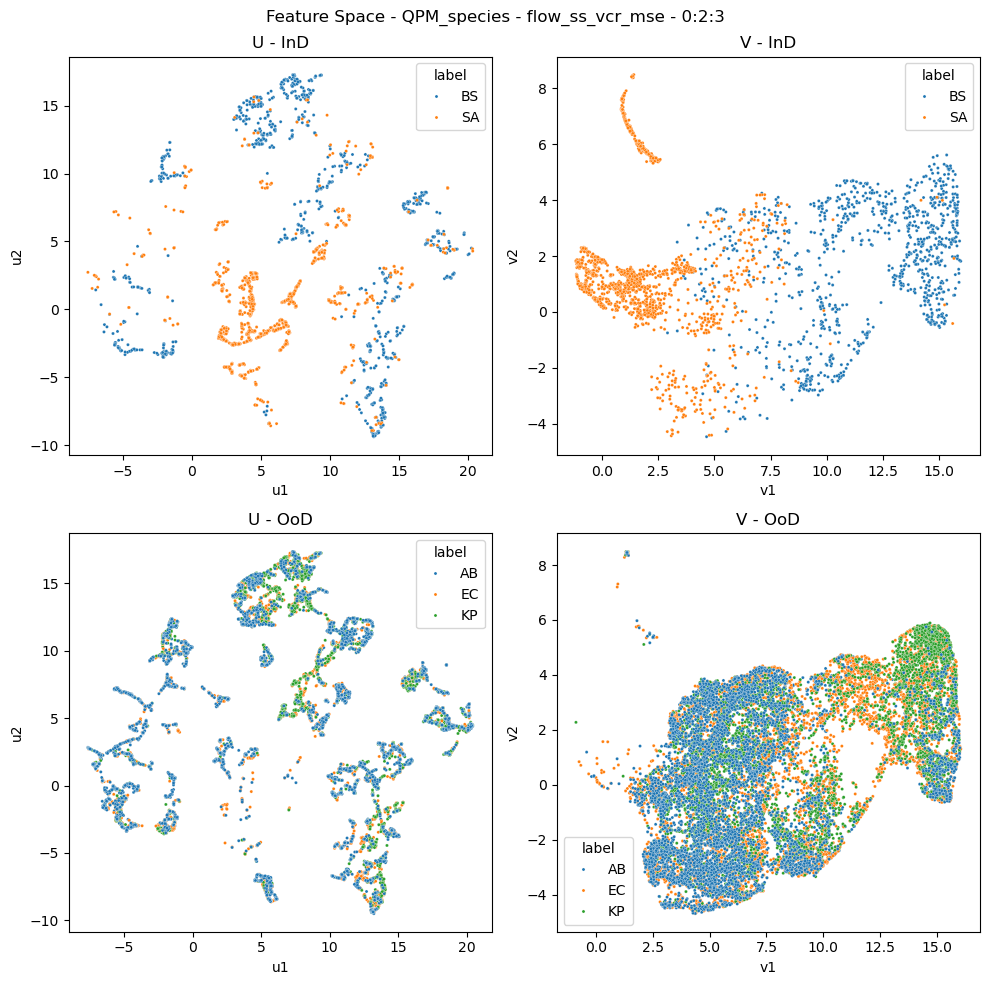

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

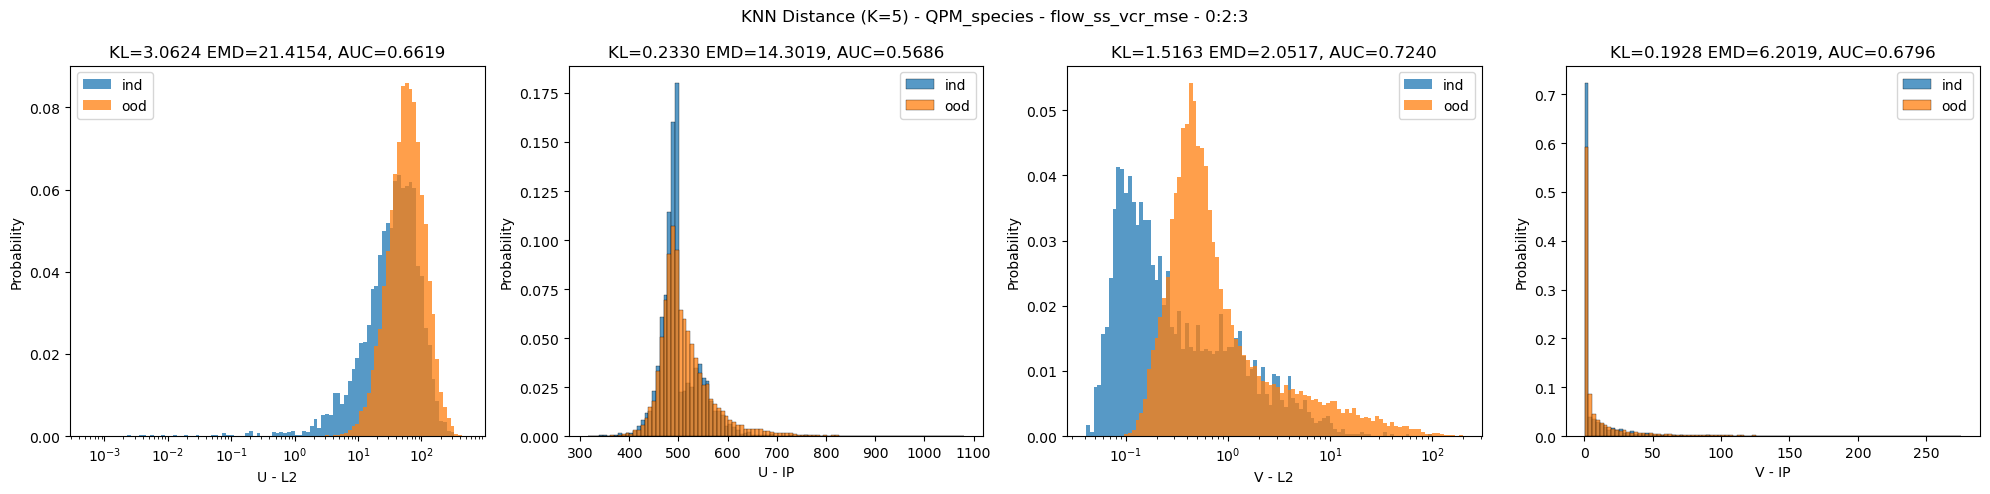

In [13]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_u_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_e_u, val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="logspace")
axs[0].set_xlabel("U - L2")
run_stats["knn_u_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_e_u, val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="linspace")
axs[1].set_xlabel("U - IP")
run_stats["knn_v_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], trn_e_v, val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="logspace")
axs[2].set_xlabel("V - L2")
run_stats["knn_v_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], trn_e_v, val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="linspace")
axs[3].set_xlabel("V - IP")
plt.tight_layout()
plt.show()

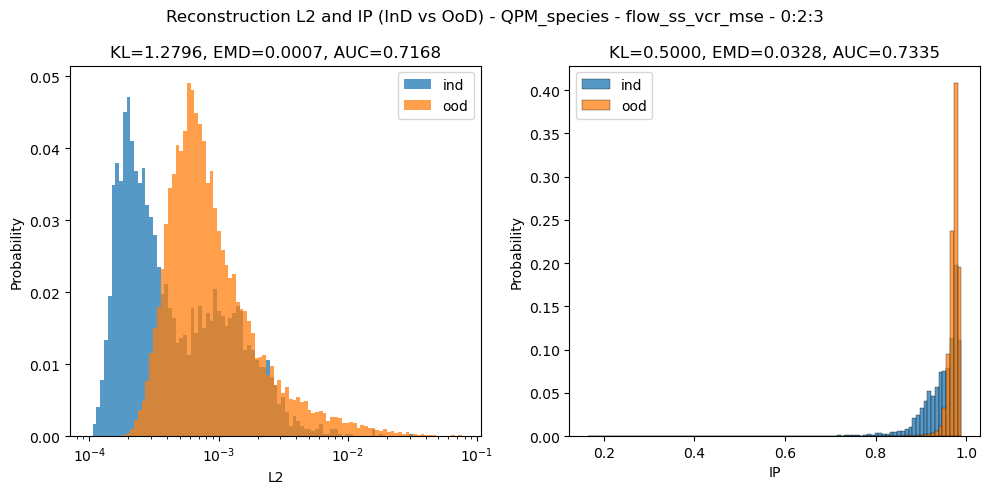

In [14]:
# plot reconstruction-based ood metrics
def plot_rcn(val_rcn, ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=val_rcn.tolist(), ind_data=ind_rcn.tolist(), ood_data=ood_rcn.tolist()))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)


# training data
_val_inp, _val_rcn = flatten(val_inp), flatten(val_rcn)
_val_inp_unit, _val_rcn_unit = unit(_val_inp), unit(_val_rcn)
# metrics
val_rcn_l2 = ((_val_inp - _val_rcn) ** 2).mean(-1)
val_rcn_ip = (_val_inp_unit * _val_rcn_unit).sum(-1)

# ind test data
_ind_inp, _ind_rcn = flatten(ind_inp), flatten(ind_rcn)
_ind_inp_unit, _ind_rcn_unit = unit(_ind_inp), unit(_ind_rcn)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # ood test data
    _ood_inp, _ood_rcn = flatten(ood_inp), flatten(ood_rcn)
    _ood_inp_unit, _ood_rcn_unit = unit(_ood_inp), unit(_ood_rcn)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
run_stats["rcn_l2"] = plot_rcn(val_rcn_l2, ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(val_rcn_ip, ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)

if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)

run_stats["norm_u"] = dict(val_data=val_n_u.tolist(), ind_data=ind_n_u.tolist(), ood_data=ood_n_u.tolist() if ood_str else None)
run_stats["norm_v"] = dict(val_data=val_n_v.tolist(), ind_data=ind_n_v.tolist(), ood_data=ood_n_v.tolist() if ood_str else None)

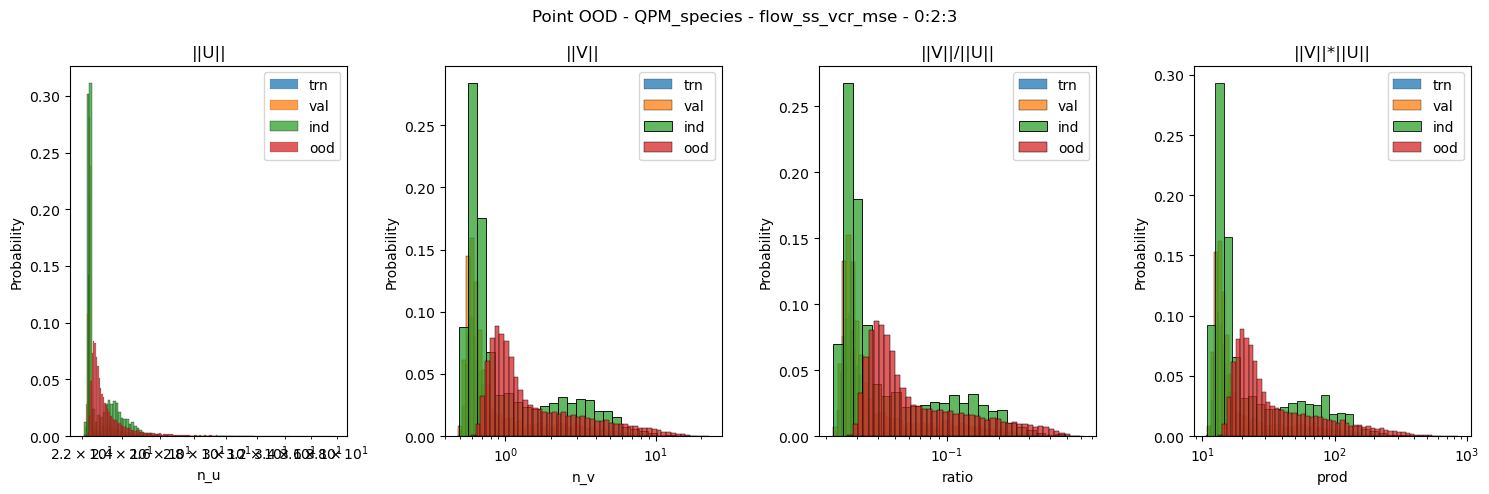

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


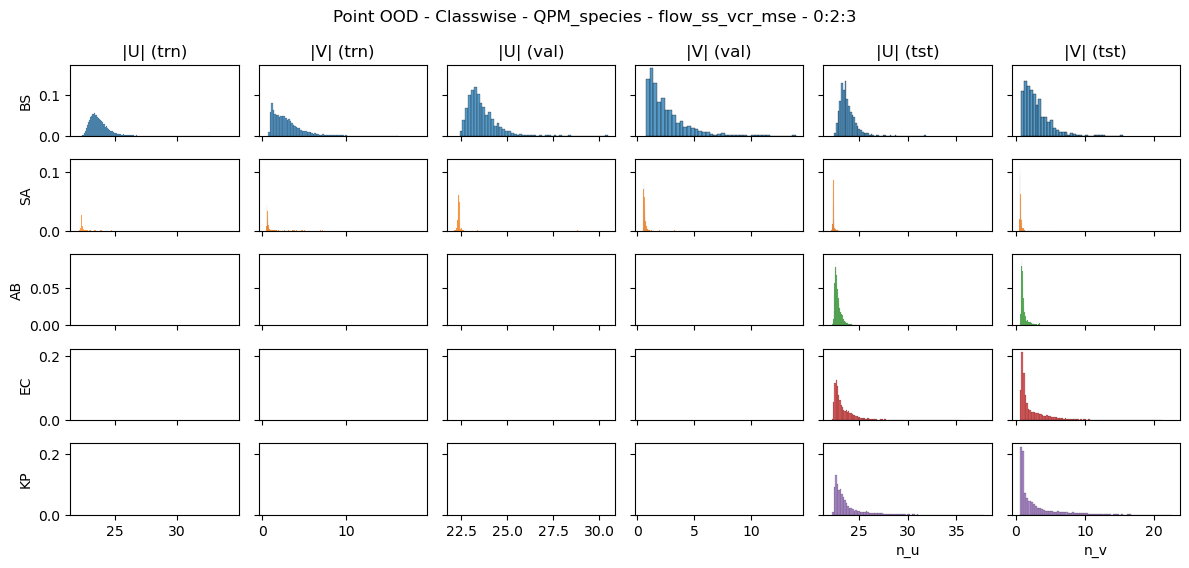

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

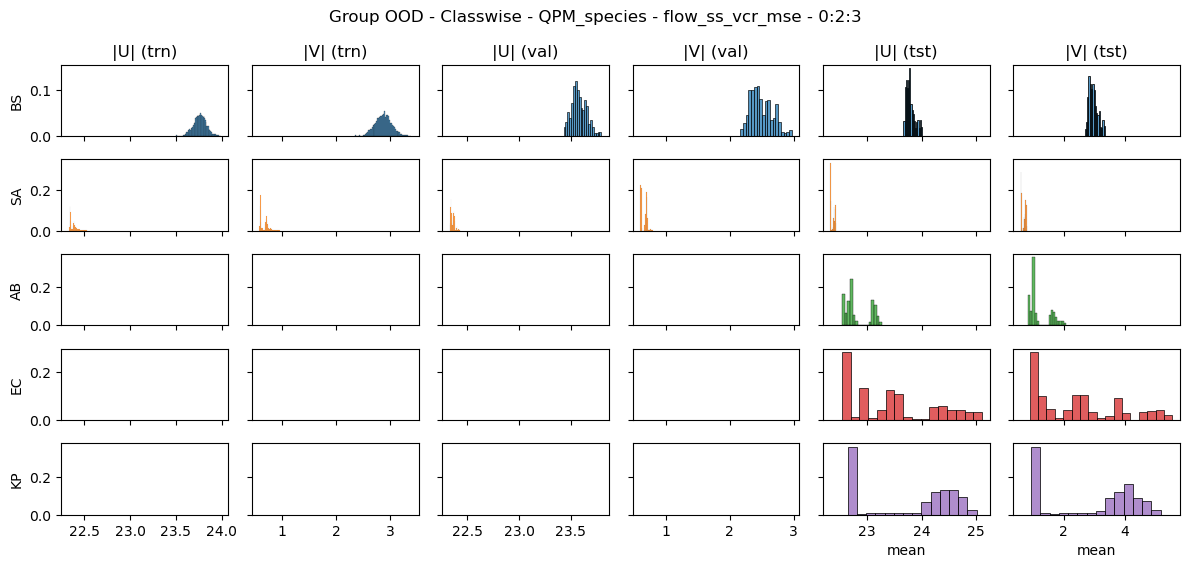

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

In [20]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))
import gzip
import pickle
with gzip.open(f"{save_name}_stats.gz", "wb") as f:
    pickle.dump(run_stats, f)